In [4]:
%matplotlib inline
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import scipy.misc as smp

In [3]:
fs, w = wavfile.read('s1.wav') # fs = sample rate
w = w.T[0] # use only first channel

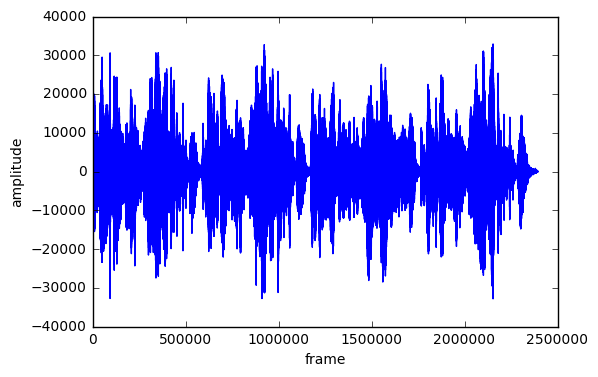

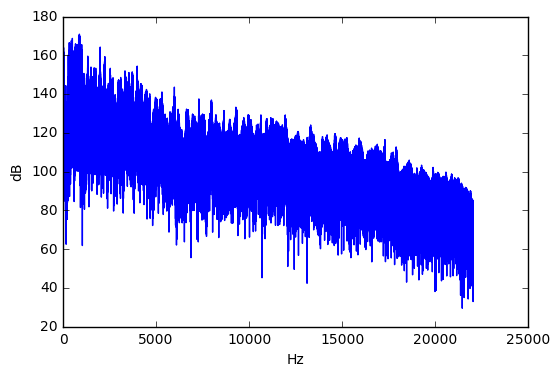

In [4]:
plt.plot(w)
plt.xlabel("frame")
plt.ylabel("amplitude")
plt.show()

amp = np.abs(np.fft.rfft(w))
Xdb = 20*np.log10(amp)
f = np.linspace(0, fs/2, Xdb.size)
plt.plot(f, Xdb)
plt.xlabel('Hz')
plt.ylabel('dB')
plt.show()

In [32]:
def compute_acoustic_indices(w, total_length, t, fbs=256, fs=44100):
    """
    w : wav file
    total_length : total length of the recording (in seconds)
    t: time span for three indices (in seconds)
    fbs : number of frequency bins
    fs : sample rate of the wav file
    """
    freqs = np.linspace(0, fs/2, fbs)
    N = t*fs//(2*fbs) # number of cells in each time span
    aci_matrix = []
    h_t_matrix = []
    cvr_matrix = []
    for j in range(0, total_length//t): # for each time span
        amps = np.array([np.abs(np.fft.rfft(w[j*fs+i*2*fbs:j*fs+(i+1)*2*fbs], 2*fbs))[:fbs] for i in range(0, N)]) # fft the corresponding segment
        aci = np.sum(np.abs(np.diff(amps,axis=0)),axis=0)/np.sum(amps,axis=0) # aci vector
#         aci_avg = np.average(aci[14:]) # remove low freqs, this is aci_index (not used at the moment)
        aci_matrix.append(aci)
        prob_masses = [amps[:,i]**2/np.sum(amps[:,i]**2) for i in range(0,fbs)] # entropy for each freq bin
        entropies = [entropy(e)/np.log2(N) for e in prob_masses] # H[t] vector
#         e = np.abs(np.fft.rfft(w))**2
#         h_t = entropy(e/np.sum(e))/np.log2(N) # entropy of the signal
        h_t_matrix.append(entropies)
    
        
        amps_mean = np.average(amps,axis=0)
        amps_std = np.std(amps,axis=0)
        noise = amps_mean+0.1*amps_std
        dbs = 20*np.log10(amps-noise)
        cvr = np.sum(dbs>2,axis=0)/dbs.shape[0] # cvr vector
#         cvr_avg = np.average(cvr[14:]) # cvr_index (not used)
        cvr_matrix.append(cvr)
    return freqs, np.array(aci_matrix), np.array(h_t_matrix), np.array(cvr_matrix)

In [33]:
freqs, aci_matrix, h_t_matrix, cvr_matrix = compute_acoustic_indices(w, 30, 1)

C:\Users\kwea\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in log10
C:\Users\kwea\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: invalid value encountered in greater


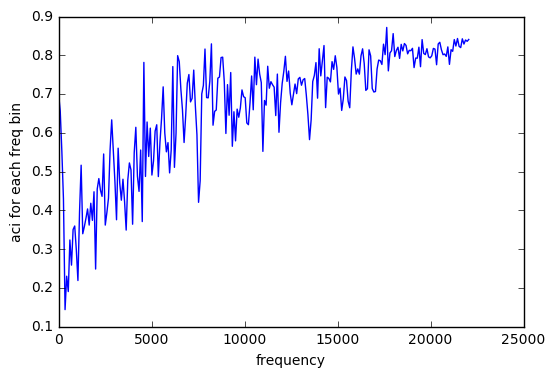

In [34]:
plt.plot(freqs, aci_matrix[0])
plt.xlabel('frequency')
plt.ylabel("aci for each freq bin")
plt.show()

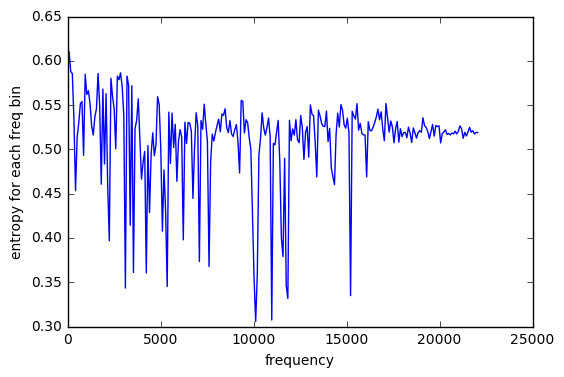

In [35]:
plt.plot(freqs, h_t_matrix[0])
plt.xlabel('frequency')
plt.ylabel("entropy for each freq bin")
plt.show()

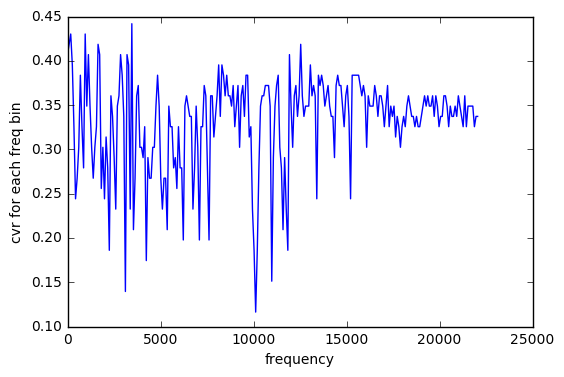

In [36]:
plt.plot(freqs, cvr_matrix[0])
plt.xlabel('frequency')
plt.ylabel("cvr for each freq bin")
plt.show()

In [37]:
def normalize(matrix, lb, ub, asint):
    """
    linearly normalize @matrix w.r.t lb:lower bound and ub:upper bound
    asint: return 8bit integers
    """
    m = np.copy(matrix)
    m = (m-lb)/(ub-lb)
    m[m>1] = 1
    m[m<0] = 0
    if asint:
        return (256*m).astype(np.uint8)
    return m

In [38]:
r = normalize(aci_matrix,0.4,0.7,True)
g = 1-normalize(h_t_matrix,0.5,0.98,True)
b = normalize(cvr_matrix,0.0,0.3,True)

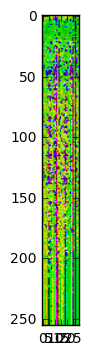

In [39]:
img_data = np.stack((r,g,b),axis=2)
plt.imshow(img_data.swapaxes(0,1))

modify index,
long data
compute indices without storing
test fft speed (using static data)


In [119]:
aci_matrix[0]

array([ 0.69992467,  0.65618989,  0.55251962,  0.42930468,  0.14355509,
        0.22977919,  0.19016382,  0.32330346,  0.25839867,  0.35025643,
        0.35936628,  0.2977356 ,  0.21865676,  0.39537581,  0.51625689,
        0.33936901,  0.35787183,  0.37942945,  0.40335663,  0.36171206,
        0.41806133,  0.37390246,  0.44769219,  0.24828881,  0.45484183,
        0.48175949,  0.45189541,  0.43588839,  0.54521464,  0.36172516,
        0.39392717,  0.43116944,  0.55640371,  0.63325022,  0.55299986,
        0.4741313 ,  0.37546465,  0.56015911,  0.47035926,  0.42589352,
        0.480092  ,  0.42245105,  0.34879923,  0.47793879,  0.52211769,
        0.50385885,  0.36395347,  0.5485948 ,  0.61408616,  0.48776293,
        0.44869767,  0.5554167 ,  0.37078069,  0.78151751,  0.48721647,
        0.62774928,  0.53878327,  0.61194258,  0.49083913,  0.52720271,
        0.60430276,  0.62059546,  0.4869203 ,  0.57513679,  0.63704263,
        0.71842387,  0.59953885,  0.55077101,  0.57450518,  0.49

In [297]:
size = 4500
amps = np.array([np.abs(np.fft.rfft(w[i*512:(i+1)*512], 512))[:256] for i in range(0, size)])
h_t_true = 0
h_t_approx3 = 0
sumSquared = 0
data = amps[:,7]
ratio = []
for j in range(0,size):
    a_j_2 = data[j]*data[j]
#     a_j_2 = 1
    factor_j = sumSquared/(sumSquared+a_j_2)
    factor2_j = (factor_j-0.5)*(factor_j-0.5)
    factor4_j = factor2_j*factor2_j
    if(factor_j!=0):
        h_t_true = h_t_true*factor_j-factor_j*np.log2(factor_j)-(1.0-factor_j)*np.log2(1.0-factor_j)
    h_t_approx3 = h_t_approx3*factor_j-96*factor4_j*factor4_j-2.5*factor2_j+1.0005
#     h_t_approx3 = h_t_approx3*factor_j-10.407*(factor_j-1)
    sumSquared += a_j_2
    if(j>0):
        ratio.append(h_t_true/h_t_approx3)

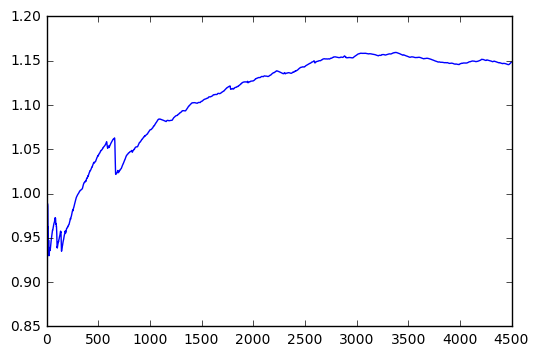

In [298]:
plt.plot(ratio)
# t = np.arange(0, size, 1)
# s = np.log(t+100)/8+0.25
# plt.plot(s)

In [307]:
print(h_t_true)
print(h_t_approx3*1.3/1.15)
print(np.abs(h_t_true-h_t_approx3*1.3/1.15)/h_t_true)
# print(h_t_approx3*(np.log(size+100)/8+0.25))
# print(np.abs(h_t_true-h_t_approx3*(np.log(size+100)/8+0.25))/h_t_true)

10.3992214219
10.6341662658
0.0225925417295


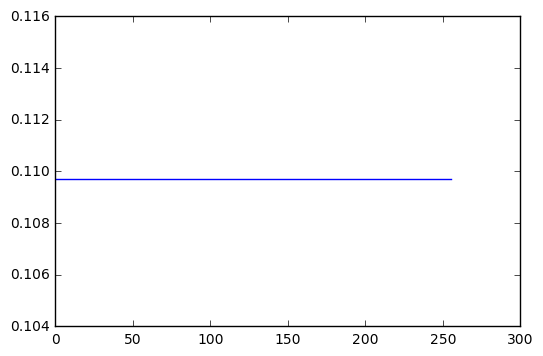

In [5]:
relative_err = []
for i in range(0,256):
#     data = amps[:,i]
    h_t_true = 0
    h_t_approx3 = 0
    sumSquared = 0
    for j in range(0,4500):
#         a_j_2 = data[j]*data[j]
        a_j_2 = 1
#         a_j_2 = np.random.normal(30000,5000)
        factor_j = sumSquared/(sumSquared+a_j_2)
        factor2_j = (factor_j-0.5)*(factor_j-0.5)
        factor4_j = factor2_j*factor2_j
        if(factor_j!=0):
            h_t_true = h_t_true*factor_j-factor_j*np.log2(factor_j)-(1.0-factor_j)*np.log2(1.0-factor_j)
        h_t_approx3 = h_t_approx3*factor_j-96*factor4_j*factor4_j-2.5*factor2_j+1.0005
        sumSquared += a_j_2
    relative_err.append(np.abs(h_t_true-h_t_approx3*1.3/1.15)/h_t_true)
plt.plot(relative_err)

(array([ 95.,  60.,  30.,  34.,  13.,  11.,   8.,   2.,   1.,   2.]),
 array([  1.74474041e-04,   2.66067530e-02,   5.30390320e-02,
          7.94713110e-02,   1.05903590e-01,   1.32335869e-01,
          1.58768148e-01,   1.85200427e-01,   2.11632706e-01,
          2.38064985e-01,   2.64497264e-01]),
 <a list of 10 Patch objects>)

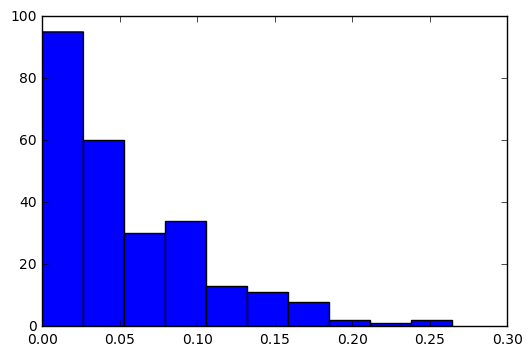

In [309]:
plt.hist(relative_err)

(array([  2.64000000e+02,   1.10000000e+01,   1.20000000e+01,
          1.30000000e+01,   9.00000000e+00,   1.30000000e+01,
          2.00000000e+01,   9.00000000e+00,   7.00000000e+00,
          1.50000000e+01,   1.20000000e+01,   1.40000000e+01,
          1.40000000e+01,   1.50000000e+01,   1.20000000e+01,
          1.50000000e+01,   9.00000000e+00,   1.10000000e+01,
          1.10000000e+01,   1.00000000e+01,   8.00000000e+00,
          9.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          6.00000000e+00,   9.00000000e+00,   1.20000000e+01,
          5.00000000e+00,   1.10000000e+01,   6.00000000e+00,
          7.00000000e+00,   9.00000000e+00,   4.00000000e+00,
          7.00000000e+00,   6.00000000e+00,   7.00000000e+00,
          4.00000000e+00,   5.00000000e+00,   7.00000000e+00,
          7.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   3.00000000e+00,   3.00000000e+00,
        

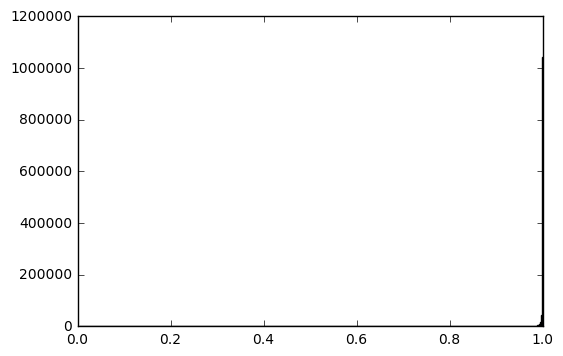

In [246]:
fact = []
for i in range(0,256):
    data = amps[:,i]
    h_t_true = 0
    h_t_approx3 = 0
    sumSquared = 0
    for j in range(0,size):
        a_j_2 = data[j]*data[j]
#         a_j_2 = 1
#         a_j_2 = np.random.normal(30000,5000)
        factor_j = sumSquared/(sumSquared+a_j_2)
        sumSquared += a_j_2
        fact.append(factor_j)
plt.hist(fact,bins=500)